In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
from skimage import exposure 
from skimage.exposure import match_histograms 
from skimage.morphology import (erosion, dilation, closing, opening)
from PIL import Image
from skimage.feature import canny

from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage.draw import circle_perimeter
from skimage import color, img_as_ubyte
import skimage
from skimage import measure
from skimage import io, morphology
from scipy.spatial import distance
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

In [2]:
from load_images import load_images_from_folder

In [3]:
def show_images(images) :
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i],cmap='gray', vmin=0, vmax=255)

    plt.show()

In [4]:
def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])
    
    if abs(det) < 1.0e-6:
        return (None, np.inf)
    
    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det
    
    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

In [5]:
def define_point_one(x,y):
    """
     Return the first point on the circular arc of the OD located on the left side
     
    """    
    ind_y=[p for p,q in enumerate(y) if q==min(y)]    
    cent='false'     
    if abs(np.subtract(min(x[ind_y]),x.min()))>15 and abs(np.subtract(max(x[ind_y]),x.max()))>15:
        cent='true'
       # print(cent)
        ind_x=[p for p,q in enumerate(x) if q==min(x)]
        point_one=(y[ind_x[0]],x[ind_x[0]])
       # print(f'point_one:{point_one}')
        polint_location='top'
    
    if abs(np.subtract(min(x[ind_y]),x.min()))>abs(np.subtract(max(x[ind_y]),x.max())) and cent=='false':
        #point :down
        ind_x=[p for p,q in enumerate(x[ind_y]) if q==max(x[ind_y])]
        point_one=(y[ind_y[ind_x[0]]],x[ind_y[ind_x[0]]])
        polint_location='down'
    elif abs(np.subtract(min(x[ind_y]),x.min()))<=abs(np.subtract(max(x[ind_y]),x.max())) and cent=='false':
        ind_x=[p for p,q in enumerate(x[ind_y]) if q==min(x[ind_y])]      
        point_one=(y[ind_y[ind_x[0]]],x[ind_y[ind_x[0]]])
        polint_location='top'   
   # print(f'point_one : {point_one}')
    return point_one,polint_location

def define_point_two(x,y,coords,point_location) :
    """
     Return the second point on the circular arc of the OD located on the left side
     
    """ 
    if point_location == 'top':        
        ind_x=[p for p,q in enumerate(x) if q==max(x)]
       # print(y[ind_x])
        ind_y=[p for p,q in enumerate(y[ind_x]) if q==min(y[ind_x])][0]
        y[ind_y]
        coords
        cordinates=[]
        for i in range(len(coords)):
            if coords[i][0]<=y[ind_x[ind_y]] and coords[i][1]> (x.min()+x.max())/2:
                cordinates.append(i) 
        if len(cordinates) !=0 :
            point_two=coords[cordinates[-1]]  
    else:
        ind_x=[p for p,q in enumerate(x) if q==min(x)]
        y[ind_x]
        ind_y=[p for p,q in enumerate(y[ind_x]) if q==min(y[ind_x])][0]
        cordinates=[]
        for i in range(len(coords)):
            if coords[i][0]<y[ind_y] and coords[i][1]< (x.min()+x.max())/2:
                cordinates.append(i)      
        if len(cordinates) !=0:
            point_two=coords[cordinates[0]]
        else:
            point_two=(y[ind_y],x[ind_x][0])
    #print(f'point2 : {point_two}')        
    return point_two
        
def define_3_point(x,y):
    """
    Return the tree points on the circular arc of the OD located on the left side
    """
    coords=list(zip(y, x))    
    point_one,point_location=define_point_one(x,y)
    point_two= define_point_two(x,y,coords,point_location)
    distance1,distance2 = [],[]
    coords1=[]
    for ii in range(len(coords)):
        if coords[ii][0]> (int((y.max()-y.min())/2)+y.min()) and coords[ii][1]> x.min():
            coords1.append(ii)
            distance1.append(distance.euclidean(coords[ii],point_one))#coords[ind[0][0]]))
            distance2.append(distance.euclidean(coords[ii],point_two))#coords[ind[1][0]]))
    sub_dist=list(abs(np.subtract(distance1,distance2)))
    ind1=[p for p,q in enumerate(sub_dist) if q==min(sub_dist)][0]    
    pts = np.array([list(coords[coords1[ind1]]),point_one,point_two])
    return pts

In [6]:
def define_point_one_2(x,y):
    
    ind_y=[p for p,q in enumerate(y) if q==max(y)]    
    cent='false'    
    if abs(np.subtract(min(x[ind_y]),x.min()))>=15 and abs(np.subtract(max(x[ind_y]),x.max()))>=15:
        cent='true'
        #print(cent)
        ind_x=[p for p,q in enumerate(x) if q==min(x)]
        point_one=(y[ind_x[0]],x[ind_x[0]])
        polint_location='top'   
    if abs(np.subtract(min(x[ind_y]),x.min()))> abs(np.subtract(min(x[ind_y]),x.max())) and cent=='false':
        #point :down
        ind_x=[p for p,q in enumerate(x[ind_y]) if q==max(x[ind_y])]
        point_one=(y[ind_y[ind_x[0]]],x[ind_y[ind_x[0]]])
        polint_location='down'
    elif abs(np.subtract(min(x[ind_y]),x.min()))<= abs(np.subtract(min(x[ind_y]),x.max())) and cent=='false':
        ind_x=[p for p,q in enumerate(x[ind_y]) if q==min(x[ind_y])]        
        point_one=(y[ind_y[ind_x[0]]],x[ind_y[ind_x[0]]])
        polint_location='top'        
   # print(f'point_one :{point_one}')
    return point_one,polint_location

def define_point_two_2(x,y,coords,point_location) :
   
    print(point_location)
    if point_location == 'top':
        ind_x=[p for p,q in enumerate(x) if q==max(x)]
        ind_y=[p for p,q in enumerate(y[ind_x]) if q==max(y[ind_x])][0]      
        coords
        cordinates=[]
        for i in range(len(coords)):
            if (coords[i][0]>= y[ind_x[ind_y]] and coords[i][1]> (x.min()+x.max())/2 and
            abs(np.subtract(coords[i][1],x[ind_x[ind_y]]))<10):#int(x.max()-x.min())/6
                cordinates.append(i)  
        if len(cordinates) !=0:
            point_two=coords[cordinates[0]]
        else:
            point_two=(y[ind_x[ind_y]],x[ind_x[ind_y]])
            
        if len(cordinates) !=0:
            point_two=coords[cordinates[0]]  
    else:
        ind_x=[p for p,q in enumerate(x) if q==min(x)]
        y[ind_x]
        ind_y=[p for p,q in enumerate(y[ind_x]) if q==max(y[ind_x])][0]
        cordinates=[]
        for i in range(len(coords)):
            if coords[i][0]>y[ind_y] and coords[i][1]< (x.min()+x.max())/2:
                cordinates.append(i)
      
        if len(cordinates) !=0:
            point_two=coords[cordinates[0]]
        else:
            point_two=(y[ind_y],x[ind_x][0])
    #print(f'point_two:{point_two}')        
    return point_two
        
def define_3_point_2(x,y):
    """
    Return the tree points on the circular arc of the OD located on the rigth side
    """
    coords=list(zip(y, x))    
    point_one,point_location=define_point_one_2(x,y)
    point_two= define_point_two_2(x,y,coords,point_location)
    distance1,distance2 = [],[]
    cordinates=[]
    for ii in range(len(coords)):
        if coords[ii][0] < min(point_one[0],point_two[0]):
            
            cordinates.append(ii)
            distance1.append(distance.euclidean(coords[ii],point_one))#coords[ind[0][0]]))
            distance2.append(distance.euclidean(coords[ii],point_two))#coords[ind[1][0]]))
    sub_dist=list(abs(np.subtract(distance1,distance2)))
   # print(f'cordinates:{cordinates}')
    ind1=[p for p,q in enumerate(sub_dist) if q==min(sub_dist)][0]    
    pts = np.array([list(coords[cordinates[ind1]]),point_one,point_two])
    return pts

In [7]:
def detect_blob(image_gray):
    """
    Retuen the center and radius of the circular OD boundary by using blob algorithm  
    """
   
    blobs_log = blob_log(np.uint8(image_gray)*255,max_sigma=40, num_sigma=10,  threshold=.01)#max_sigma=20, num_sigma=10,
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2) 

    radius=[]
    for i in range(blobs_log.shape[0]) :
        radius.append(int(blobs_log[i,2]))

    ind=[p for p,q in enumerate(radius) if q==max(radius)][0]
    y=blobs_log[ind,1]#row
    x=blobs_log[ind,0]#column
    r = blobs_log[ind,2]
    cv2.circle(im_original, (int(y),int(x)), int(r), (255, 0, 0), 2)
    return y,x,r


In [8]:
def reshaping_original_size(ctr_y,ctr_x,r,im_original,im00_0):
    if np.subtract(round(ctr_y),r)>=0:
        first_row=np.subtract(round(ctr_y),round(r))
    else:
        first_row=0
        
    if np.add(round(ctr_y),r)<=im_original.shape[0] :
        second_row=np.add(round(ctr_y),round(r))
    else:
        second_row=im_original.shape[0]
        
    if np.subtract(round(ctr_x),r)>=0:
        first_col=np.subtract(round(ctr_x),round(r))
    else:
        first_col=0
        
    if np.add(round(ctr_x),r)<=im_original.shape[1] :
        second_col=np.add(round(ctr_x),round(r))
    else:
        second_col=im_original.shape[0]
        
    im00=np.zeros((im_original.shape[1],im_original.shape[0]), dtype=np.uint8())
    im00[first_row:second_row,first_col:second_col]=im00_0
    
    return im00

In [16]:
### loading data

data_path='./all/all/'
images,images_name=load_images_from_folder(data_path)

top


/home/asieh/miniconda3/envs/anamolly_detection/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice.


top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
top
down
top
top
top
top
top
top
down
top
top
top
down
down
top
top
top


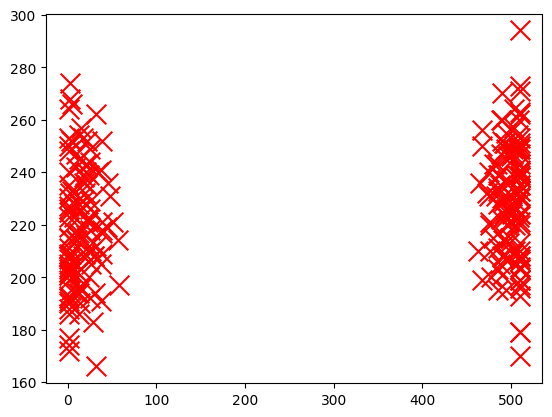

In [30]:
save_path_cup_prp='./cup_pre_processed/'
path_candidate_cup='./cup_candidates/'
save_path_cup_boundary='./cup_boundary/'
if not os.path.exists(save_path_cup_boundary):
        os.makedirs(save_path_cup_boundary)

kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
df=pd.read_csv("OD_information.csv")
count=0
list_values=[]
for filename in os.listdir(path_candidate_cup):
   # print(filename)
   # filename='ahmadi_s_377.OD.png'+'.png'
    ind=[ii for ii,x in enumerate(list(df['image_name'])) if x==filename]
    ctr_x=df['OD_center_x'][ind[0]]#column 
    ctr_y=df['OD_center_y'][ind[0]]#row-
    r=df['OD_width'][ind[0]]
    OD_loaction=df['OD_location'][ind[0]]
    
    im_original=cv2.imread(os.path.join(data_path,filename))
    im_original = cv2.cvtColor(im_original, cv2.COLOR_BGR2GRAY)  
    im_original=cv2.resize(im_original,(512,512))
    im_original = color.gray2rgb(im_original)
    
    im00_0=cv2.imread(os.path.join(path_candidate_cup,filename))
    im00_0 = cv2.cvtColor(im00_0, cv2.COLOR_BGR2GRAY) 
    
    im_win=cv2.imread(os.path.join(save_path_cup_prp,filename))
    im00_0=cv2.resize(im00_0,(im_win.shape[1],im_win.shape[0]))
    ### reshaping the window to the original size
    im00=reshaping_original_size(ctr_y,ctr_x,r,im_original,im00_0)
    #*********
    im00_opend=np.uint8(opening(im00.copy(),kernel))    
    im01=np.multiply(np.uint8(morphology.remove_small_objects(im00_opend>0,50)),im00)
    im0=np.multiply(np.uint8(closing(im01.copy(),kernel)),im00)
    
    x,y=np.where(im0!=0)
    th=im0[x,y].mean()
    labels = measure.label(np.where(im0>0,1,0),connectivity=2) 
    labels1=labels.copy()
    propsa = measure.regionprops(labels)
    num_propsa = len(propsa)
    
    
    Areas=[]
    I_mean=[]
    im1=im0.copy()
    label_remaind=[]
    
    for label in propsa:
        
        candidate_asessed=0
        ###the ratio of cup candidate radius to Disc region radius
        if candidate_asessed==0 and np.linalg.norm(np.subtract(np.array((ctr_y,ctr_x)),np.array(label.centroid)))/r> 0.75 :
            num_propsa -= 1
            im1[label.coords[:,0],label.coords[:,1]]=0
            candidate_asessed=1
        
        if candidate_asessed==0 and im0[label.coords[:,0],label.coords[:,1]].mean()<(0.5*th) :
            num_propsa -= 1
            im1[label.coords[:,0],label.coords[:,1]]=0
            candidate_asessed=1
        if candidate_asessed==0:
            label_remaind.append(label)
            Areas.append(label.area)
            I_mean.append(im0[label.coords[:,0],label.coords[:,1]].mean())
            
   
    dist=[]
    if len(label_remaind) >1 and num_propsa!=0 and OD_loaction == 'disc_center' :
        for label1 in label_remaind:
            #label1.centroid : tuple type: the fisrt and second element indicate row and col, respectively
            dist.append(np.linalg.norm(np.subtract(np.array((ctr_y,ctr_x)),np.array(label1.centroid))))
        ind1=[ii for ii,x in enumerate(dist) if x==min(dist)]         
        label_remaind2=label_remaind[ind1[0]]
       # print(label_remaind[ind1[0]])
    elif len(label_remaind) >1 and num_propsa!=0 and OD_loaction == 'macula_center' :
        ind1=[ii for ii,x in enumerate(I_mean) if x==max(I_mean)]
        label_remaind2=label_remaind[ind1[0]]
        
    elif len(label_remaind)==1 and num_propsa!=0 :
        label_remaind2=label_remaind[0]
       
    if OD_loaction == 'disc_center' and num_propsa!=0:
            
            IM0=np.zeros(im0.shape, dtype=np.uint8)
            hight_width=(label_remaind2.bbox[2]-label_remaind2.bbox[0]) /(label_remaind2.bbox[3]-label_remaind2.bbox[1])
            width_higth=(label_remaind2.bbox[3]-label_remaind2.bbox[1]) /(label_remaind2.bbox[2]-label_remaind2.bbox[0])
            condition_1=np.subtract(label_remaind2.bbox[1] ,np.subtract(ctr_x,r))>1
            condition_2=np.subtract(np.add(ctr_x,r), label_remaind2.bbox[3])> 1
            condition_3=np.subtract(np.add(ctr_y,r), label_remaind2.bbox[2])> 1
            condition_4=np.subtract(label_remaind2.bbox[0] ,np.subtract(ctr_y,r))> 1
            condition_5=label_remaind2.area>400
            if condition_1 and condition_2 and condition_3 and condition_4 and condition_5 :#and label_remaind2.area>700:
               
                IM0[label_remaind2.coords[:,0],label_remaind2.coords[:,1]]=1
                IM=IM0
                image_gray   = skimage.morphology.convex_hull_object(IM, connectivity=2)              
                im0_color = color.gray2rgb(img_as_ubyte(np.uint8(np.where(im0>0,1,0)*255)))
                y_cup,x_cup,r_cup=detect_blob(image_gray)                
                cv2.circle(im_original, (int(y_cup),int(x_cup)), int(r_cup), (0, 255, 0), 2)
                list_values.append([filename, y_cup, x_cup,  r_cup])
                
    if OD_loaction == 'macula_center' and  num_propsa!=0:
        IM0=np.zeros(im0.shape, dtype=np.uint8)
        IM0[label_remaind2.coords[:,0],label_remaind2.coords[:,1]]=1
        IM=IM0
        if label_remaind2.bbox[1]< (im00.shape[0]/2):
            condition_1=np.subtract(np.add(ctr_x,r),label_remaind2.bbox[3] )> 1
            condition_2=np.subtract(np.add(ctr_y,r),label_remaind2.bbox[2] )> 1
            condition_3=np.subtract(label_remaind2.bbox[0],np.subtract(ctr_y,r) )> 1
            candition_4 = label_remaind2.area>150
            
            if condition_1 and condition_2 and condition_3 and candition_4:
                
                image_gray   = skimage.morphology.convex_hull_object(IM, connectivity=2)
                edges=np.uint8(canny(np.uint8(image_gray)*255))
                x,y=np.where(edges!=0)#x:row,y:col
                pts = define_3_point(x,y)
                plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=200)    
               # center: tuple type :first element:column, second element:row
                center, radius = define_circle(tuple(pts[0,:]),tuple(pts[1,:]),tuple(pts[2,:]))
                if radius< r:
                    cv2.circle(im_original, (int(center[0]),int(center[1])), int(radius), (0, 255, 0), 2)
                    list_values.append([filename, center[0], center[1], radius])
                
                
        if label_remaind2.bbox[1]> (im00.shape[0]/2):
            condition_1=np.subtract(label_remaind2.bbox[1],np.subtract(ctr_x,r) )> 1
            condition_2=np.subtract(np.add(ctr_y,r),label_remaind2.bbox[2] )> 1
            condition_3=np.subtract(label_remaind2.bbox[0],np.subtract(ctr_y,r) )> 1
            candition_4 = label_remaind2.area>150
            if condition_1 and condition_2 and condition_3 and candition_4:
                image_gray   = skimage.morphology.convex_hull_object(IM, connectivity=2)
                edges=np.uint8(canny(np.uint8(image_gray)*255))
                x,y=np.where(edges!=0)#x:row,y:col
                pts = define_3_point_2(x,y)
                plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=200)    
               # center: tuple type :first element:column, second element:row
                center, radius = define_circle(tuple(pts[0,:]),tuple(pts[1,:]),tuple(pts[2,:]))
                if radius< r:
                    cv2.circle(im_original, (int(center[0]),int(center[1])), int(radius), (0, 255, 0), 2)
                    list_values.append([filename, center[0], center[1], radius])
                
        
        #if (hight_width<2 and width_higth<2) and label1.area >700 and 
    
   
    cv2.circle(im_original, (int(ctr_x),int(ctr_y)), int(r), (255, 0, 255), 2)
    cv2.imwrite(save_path_cup_boundary+filename, im_original)
    if count ==0 : 
        pass
df = pd.DataFrame(list_values, columns = ['image_name','cup_center_x','cup_center_y','cup_width'])
df.to_csv('cup_information.csv', index=False)    
   